# Script to prompt LLMs

In [1]:
# import packages
import requests
import json
import pandas as pd
import os
import openai
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# If OpenAI used

# Get API key from the environment variable
api_key = os.environ.get('OPENAI_API_KEY')

# Set the API key
openai.api_key = api_key

In [59]:
# Define function to create a prompt
def create_prompt(object_name):
    #prompt = f"Generate alternative uses for the object [{object_name}]."
    prompt = f"""
        You are meant to assist students in group ideation. They are asked to propose alternative
        uses for an object and you should propose yours to give them ideas as well as inspire them to 
        explore other uses. 
        You are a very creative, open-minded person and can propose creative, out-of-the-box ideas while staying realistic. 
        Your ideas will be even more appreciated if they are original or useful in real-life or both.
        
        Generate alternative uses for the object [{object_name}]. 
        
        Provide five alternative uses, each explained in a concise sentence and following this example: "Sock: You could put it on your hands and pretend to have superpowers".
        """
        
    return prompt


# Define function to call the LLM API
def call_openai_api(prompt):
    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]#,
        #seed=seed,
        #max_tokens=200,
        #temperature=temperature,
        )
    return response


# Define function to store the result in a JSON file
def store_result_json(object_name, alternative_uses):
    result = [{"object_name": object_name, "alternative_uses": use} for use in  alternative_uses.split("\n") if use.strip()]
    with open(f"./data_ocsai/input_ocsai/aut_{object_name}.json", "w") as json_file:
        json.dump(result, json_file)


# Define function to create a CSV file and Pandas DataFrame
def create_csv_and_dataframe(object_name):
    with open(f"./data_ocsai/input_ocsai/aut_{object_name}.json", "r") as json_file:
        data = json.load(json_file)
    df = pd.DataFrame(data)
    
    # remove prefix
    df['alternative_uses'] = df['alternative_uses'].str.split(f': ').str[1]
    #df['alternative_uses'] = df['alternative_uses'].str.split(f'{object_name}: ').str[1]
    
    #rename the columns to fit ocsai format
    df = df.rename(columns={"object_name": "prompt", "alternative_uses": "response"})
    
    # save for evaluation
    df.to_csv(f"./data_ocsai/input_ocsai/aut_{object_name}.csv", index=False)
    
    return df

# Define function to estimate the price of an OpenAI API request
def estimate_price(prompt_tokens, response_tokens):
    # Define your pricing model (e.g., price per token)
    price_per_input_token = 	0.50 / 1e6
    price_per_output_token = 1.5 / 1e6
    
    # Estimate the price based on the total number of tokens
    price = (prompt_tokens * price_per_input_token) + (response_tokens * price_per_output_token)
    return price

### Main function

In [31]:
object_name = "brick"  # Example object for the Alternative Uses Test
prompt = create_prompt(object_name)

print(prompt)


        You are meant to assist students in group ideation. They are asked to propose alternative
        uses for an object and you should propose yours to give them ideas as well as inspire them to 
        explore other uses. 
        You are a very creative, open-minded person and can propose creative, out-of-the-box ideas while staying realistic. 
        Your ideas will be even more appreciated if they are original or useful in real-life or both.
        
        Generate alternative uses for the object [brick]. 
        
        Provide five alternative uses, each explained in a concise sentence and following this example: "Sock: You could put it on your hands and pretend to have superpowers".
        


In [32]:
response = call_openai_api(prompt)
response_content = response.choices[0].message.content

print(response_content)

1. Brick: Use it as a rustic doorstop to add a touch of industrial charm to your home decor.
   
2. Brick: Transform it into a unique bookend by stacking a few bricks together to stylishly display your favorite reads.

3. Brick: Create a custom DIY garden path by laying bricks in a pattern to add an aesthetic touch to your outdoor space.

4. Brick: Turn it into a makeshift weight for outdoor workouts by securely wrapping it in a cloth for grip and incorporating it into your fitness routine.

5. Brick: Use it as a makeshift pedestal to elevate a potted plant, adding height and visual interest to your indoor garden arrangement.


In [33]:
system_fingerprint = response.system_fingerprint
prompt_tokens = response.usage.prompt_tokens
completion_tokens = response.usage.total_tokens - response.usage.prompt_tokens

print(f"System fingerprint: {system_fingerprint}")
print(f"Prompt tokens: {prompt_tokens}")
print(f"Completion tokens: {completion_tokens}")

price = estimate_price(prompt_tokens, completion_tokens)
print(f"Estimated price: ${price}")

System fingerprint: fp_4f2ebda25a
Prompt tokens: 156
Completion tokens: 133
Estimated price: $0.00027749999999999997


In [60]:
store_result_json(object_name, response_content)
df = create_csv_and_dataframe(object_name)
df.head()

,prompt,response
0,brick,Use it as a rustic doorstop to add a touch of ...
1,brick,Transform it into a unique bookend by stacking...
2,brick,Create a custom DIY garden path by laying bric...
3,brick,Turn it into a makeshift weight for outdoor wo...
4,brick,Use it as a makeshift pedestal to elevate a po...


## Evaluate the creativity

### Manually

By uploading csv file here: https://openscoring.du.edu/uploadllm

In [61]:
brick_llm = pd.read_csv('./data_ocsai/input_ocsai/aut_brick.csv')
brick_llm.head()

,prompt,response
0,brick,Use it as a rustic doorstop to add a touch of ...
1,brick,Transform it into a unique bookend by stacking...
2,brick,Create a custom DIY garden path by laying bric...
3,brick,Turn it into a makeshift weight for outdoor wo...
4,brick,Use it as a makeshift pedestal to elevate a po...


In [66]:
ocsai_eval = pd.read_csv('./data_ocsai/output_ocsai/Data.csv')
ocsai_eval.head()

,prompt,response,originality,elaboration
0,brick,Use it as a rustic doorstop to add a touch of ...,1.8,NaN
1,brick,Transform it into a unique bookend by stacking...,2.0,NaN
2,brick,Create a custom DIY garden path by laying bric...,1.0,NaN
3,brick,Turn it into a makeshift weight for outdoor wo...,2.0,NaN
4,brick,Use it as a makeshift pedestal to elevate a po...,3.0,NaN


#### Comparison to ground truth

In [67]:
ground_truth = pd.read_csv('./../data/cleaned_all_data.csv')
ground_truth.head(2)

,Unnamed: 0,type,src,question,prompt,response,id,target,participant,response_num,index,count
0,0,uses,dod20,What is a surprising use for PANTS?,pants,fashion,dod20_pants-160974,1.0,dod2037,6.0,14274.0,2.0
1,1,consequences,setal08,What would be a surprising consequence if EVER...,shrank,couldn't harvest food,setal08_6.0-5d7c8c,1.3,setal08150,7.0,NaN,NaN


In [68]:
# plot mean from outputs LLMs in the histogram of ground truth
def plot_mean_histogram(ocsai_eval, ground_truth, object_name):
    plt.figure(figsize=(10, 6))
    
    object_ground_truth = ground_truth[ground_truth['prompt'] == object_name]
    
    sns.histplot(object_ground_truth['target'], kde=True, label='Humans')
    plt.vlines(ocsai_eval['originality'].mean(), 0, plt.gca().get_ylim()[1], colors='red', linestyles='dashed', label='LLM')
    plt.title(f'Human vs LLM creativity on AUT for {object_name}')
    #plt.xlabel('Mean')
    #plt.ylabel('Frequency')
    plt.legend()
    plt.show()

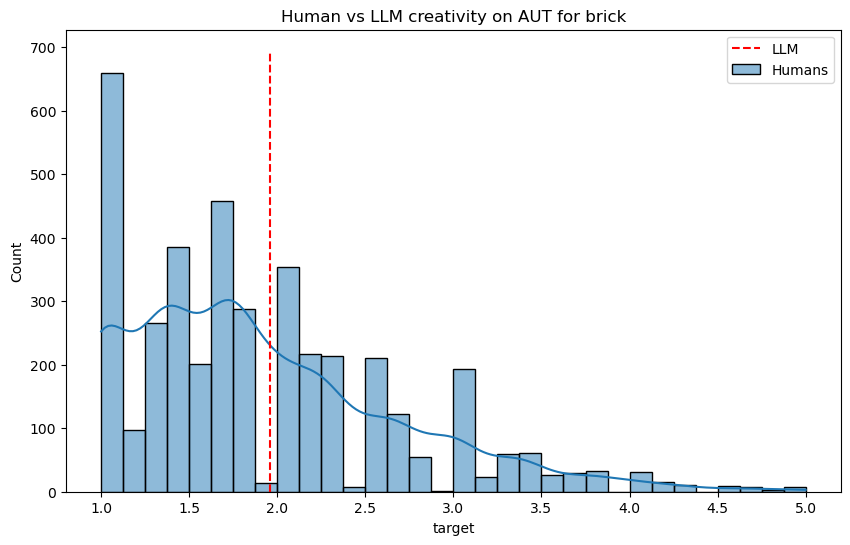

In [69]:
plot_mean_histogram(ocsai_eval, ground_truth, 'brick')

### With the API to automate process

In [35]:
# test

# Define the API endpoint
api_url = "https://openscoring.du.edu/docs"

# Example input sentences
sentences = [
    "I use a shoe as a flower pot.",
    "I use a shoe as a coaster.",
    "I use a shoe as a musical instrument."
]

# Define the request payload
payload = {
    "sentences": sentences
}

# Send POST request to the API
response = requests.get(api_url, prompt = "brick", input = './aut_brick.csv', input_type = 'csv')

# Check if request was successful
if response.status_code == 200:
    # Get the scores from the response
    scores = response.json()["score"]
    # Print the scores
    for sentence, score in zip(sentences, scores):
        print(f"Sentence: {sentence} - Score: {score}")
else:
    print("Error:", response.text)


TypeError: request() got an unexpected keyword argument 'prompt'